In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from module.base.network import Network
from module.simulation.masterequation import MasterEquation
import module.components.CONST as CONST
from module.components.discrete_gaussian1D import DiscreteGaussian1D
from module.simulation.meanfield import MeanField

from module.simulation.set_meanfield2 import SetMeanField2

In [3]:
input_voltage = 0
gate_voltage = 0

In [4]:
net = Network(1, 1, 1, [[0,0,0], [0,0,0]])
net.set_voltage_config([input_voltage, 0], gate_voltage)
me = MasterEquation(input_voltage, gate_voltage)
gaussian = DiscreteGaussian1D()

In [5]:
me_probs = me.solve(verbose = True)
me_mean = np.sum(me.phase_space * me_probs)
me_var = np.sum(me.phase_space ** 2 * me_probs) - me_mean**2
print("me mean:", me_mean)
print("me var:", me_var)

convergence: 0.0038107648278830515
me mean: -7.730132726101153e-05
me var: 0.0006758785049855436


In [6]:
gauss_probs = gaussian.calc_prob(me_mean, me_var)
gauss_mean = np.sum(gaussian.phase_space * gauss_probs)
gauss_var = np.sum(gaussian.phase_space ** 2 * gauss_probs) - gauss_mean**2
print("gauss mean:", gauss_mean)
print("gauss var:", gauss_var)

gauss mean: -7.730132726102568e-05
gauss var: 7.729535176582935e-05


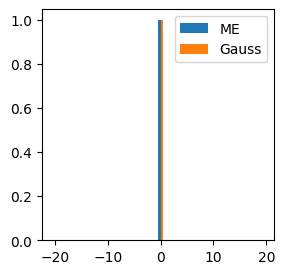

In [7]:
plt.figure(figsize = (3, 3))
plt.bar(me.phase_space - 0.25, me_probs, width = 0.5, label = "ME")
plt.bar(gaussian.phase_space + 0.25, gauss_probs, width = 0.5, label = "Gauss")
plt.legend()

In [8]:
def get_rate_to_island(phase_space):
    """
    Calculates the total rate towards the island for given phase space snippet.
    """
    space = np.expand_dims(phase_space, axis = -1)
    return net.calc_rate_from_electrode(space, 0) + net.calc_rate_from_electrode(space, 1)
    
def get_rate_from_island(phase_space):
    """
    Calculates the total rate towards the electrodes for given occupation number.
    """
    space = np.expand_dims(phase_space, axis = -1)
    return net.calc_rate_to_electrode(space, 0) + net.calc_rate_to_electrode(space, 1)

def I(phase_space):
    return get_rate_to_island(phase_space) - get_rate_from_island(phase_space)

def I_dag(phase_space):
    return get_rate_to_island(phase_space) + get_rate_from_island(phase_space)

def dN2(phase_space):
    return 2 * phase_space * I(phase_space) + I_dag(phase_space)

In [9]:
me_dN = np.sum(I(me.phase_space) * me_probs)
me_dN2 = np.sum(dN2(me.phase_space) * me_probs)
print("me dN:", me_dN)
print("me dN2:", me_dN2)

me dN: 0.0004358402317214984
me dN2: -0.00381077353679101


In [10]:
gauss_dN = np.sum(I(gaussian.phase_space) * gauss_probs)
gauss_dN2 = np.sum(dN2(gaussian.phase_space) * gauss_probs)
print("gauss dN:", gauss_dN)
print("gauss dN2:", gauss_dN2)

gauss dN: 0.00043583997974025614
gauss dN2: -0.00043583997974025614


#### Simulation
---

In [11]:
gauss_mean = me_mean - 4.8
gauss_var = me_var / 4

dt = 0.01

gauss_probs = gaussian.calc_prob(gauss_mean, gauss_var)

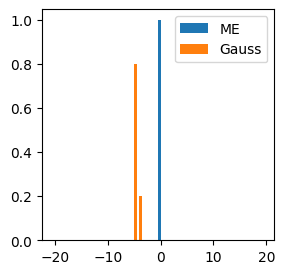

In [12]:
plt.figure(figsize = (3, 3))
plt.bar(me.phase_space - 0.25, me_probs, width = 0.5, label = "ME")
plt.bar(gaussian.phase_space + 0.25, gauss_probs, width = 0.5, label = "Gauss")
plt.legend()

In [26]:
for i in range(15):
    gauss_probs = gaussian.calc_prob(gauss_mean, gauss_var)
    gauss_dN = np.sum(I(gaussian.phase_space) * gauss_probs)
    gauss_dN2 = np.sum(dN2(gaussian.phase_space) * gauss_probs)
    gauss_dvar = gauss_dN2 - 2 * gauss_mean * gauss_dN

    gauss_mean += dt * gauss_dN
    gauss_var += dt * gauss_dvar

    print("convergence:", max(np.abs(gauss_dN), np.abs(gauss_dvar)))

convergence: 0.00016858585880602918
convergence: 0.00015908065884503463
convergence: 0.00015011138062108923
convergence: 0.00014164780782046577
convergence: 0.00013366142778322435
convergence: 0.0001261253354488179
convergence: 0.00011901414271817679
convergence: 0.00011230389292241945
convergence: 0.00010597198011400034
convergence: 9.999707291613842e-05
convergence: 9.435904265447482e-05
convergence: 8.903889555062039e-05
convergence: 8.401870873033632e-05
convergence: 7.928156984666525e-05
convergence: 7.481152010455837e-05


In [27]:
gauss_probs = gaussian.calc_prob(me_mean, me_var)
gauss_mean = np.sum(gaussian.phase_space * gauss_probs)
gauss_var = np.sum(gaussian.phase_space ** 2 * gauss_probs) - gauss_mean**2
print("gauss mean:", gauss_mean)
print("gauss var:", gauss_var)

gauss mean: -7.730132726102568e-05
gauss var: 7.729535176582935e-05


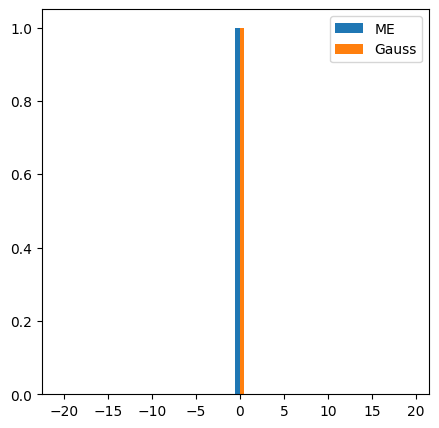

In [28]:
plt.figure(figsize = (5, 5))
plt.bar(me.phase_space - 0.25, me_probs, width = 0.5, label = "ME")
plt.bar(gaussian.phase_space + 0.25, gauss_probs, width = 0.5, label = "Gauss")
plt.legend()

In [29]:
print("comparison of means and variances of Master Equation and Mean Field:")
print("d_mean:", gauss_mean - me_mean)
print("d_var:", gauss_var - me_var)

comparison of means and variances of Master Equation and Mean Field:
d_mean: -1.4148838350935833e-17
d_var: -0.0005985831532197142


In [30]:
print("me current:", me.expected_current(me_probs))
mf = MeanField(net)
n = mf.numeric_integration_solve(verbose = True)
-(mf.calc_expected_electrode_rates(n, 1)) * CONST.electron_charge

me current: -3.491465177106649e-05
convergence: 0.0


-0.0

#### SetMeanField2 class
---

In [31]:
mf2 = SetMeanField2(input_voltage, gate_voltage)

In [32]:
mean, var = mf2.solve(verbose = True, dt = 0.01, N = 250)
print("mean:", mean)
print("var:", var)

convergence: 1.5605357774488167e-86
mean: 0.0
var: 0.0


In [33]:
mean_ = np.sum(mf2.gaussian.phase_space * mf2.gaussian.calc_prob(mean, var))
var_ = np.sum(mf2.gaussian.phase_space ** 2 * mf2.gaussian.calc_prob(mean, var)) - mean_ **2